# Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/GSDS/2022-1/MLDL1/DL/homework4'

/content/drive/MyDrive/GSDS/2022-1/MLDL1/DL/homework4


In [ ]:
! pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.6 MB/s 
     |████████████████████████████████| 138 kB 9.2 MB/s 
     |████████████████████████████████| 127 kB 67.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import math
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset

In [ ]:
"""
import modules you need
"""


'\nimport modules you need\n'

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE)) ## should be 1.11.0 and cuda
print("Using torchtext version: {}".format(torchtext.__version__)) ## should be 0.12.0

Using PyTorch version: 1.11.0+cu113, Device: cuda
Using torchtext version: 0.12.0


# Load Data

In [ ]:
"""
Load AG_NEWS dataset and set up the tokenizer and encoder pipeline.

Do NOT modify.
"""

train_data, test_data = torchtext.datasets.AG_NEWS(root='./data')

tokenizer = get_tokenizer('basic_english')

def tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

encoder = build_vocab_from_iterator(tokens(train_data), specials=["<unk>"])
encoder.set_default_index(encoder["<unk>"])

text_pipeline = lambda x: encoder(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [ ]:
def collate_batch(batch):
    """
    Creates a batch of encoded text, label and token length tensors.

    Question (a)
    - Length of token sequence in each batch is determined by 
      the average of token length of all sequences in each batch.
    - Text tensors are stacked with dimension of (TOKEN_LENGTH, BATCH),
      for easier process in RNN model.
    - Token length tensors are used to index the last valid hidden token for classification.

    Inputs
    - list of tuples, each containing an integer label and a text input
    - number of tuples in the list == BATCH SIZE
    Returns
    - text_list: batch of encoded long type text tensors with size (TOKEN_LENGTH, BATCH)
    - label_list: batch of label tensors with size (BATCH)
    - len_list: batch of token length tensors with size (BATCH)
    """

    text_list, label_list, len_list = [], [], []
    
    ### COMPLETE HERE ###
    max_token_len = np.mean([len(text_pipeline(item[1])) for item in batch]).astype(np.int64)
    for (_label, _text) in batch:
        text = text_pipeline(_text)
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text, dtype=torch.int64)
        length = processed_text.size(0)
        len_list.append(length)
        if length >= max_token_len:
            processed_text = processed_text[:max_token_len]
        else:
            processed_text = torch.cat([processed_text, torch.zeros(size=(max_token_len-length, ))])
        text_list.append(processed_text)
    
    label_list = torch.tensor(label_list, dtype=torch.int64)
    len_list = torch.tensor(len_list, dtype=torch.int64)
    text_list = torch.stack(text_list).long().permute(1, 0)

    ### COMPLETE HERE ###

    assert text_list.size(1) == len(batch)

    return text_list, label_list, len_list

In [ ]:
"""
Load the data loader.

Do NOT modify.
"""

BATCH_SIZE = 512

train_dataset = to_map_style_dataset(train_data)
test_dataset = to_map_style_dataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

In [ ]:
"""
Print out the first batch in the train loader.
Check if the collate function is implemented correctly.

Do NOT modify.
"""

for batch_x, batch_y, len_x in train_dataloader:
    print(batch_x[:10])
    print(batch_y[:10])
    print(len_x[:10])
    break

tensor([[  151,  2626,  4095,  ...,  1164,  1173,   128],
        [ 3676,   102,   910,  ...,  6822,  1710,     4],
        [   10,  1214, 10387,  ...,    12,   337,   231],
        ...,
        [   73,  1664,    28,  ...,   136,  1591,     3],
        [   15,    13,    81,  ...,  4126,   218,   347],
        [  151,    27,     4,  ...,     3,     1,    13]])
tensor([0, 3, 1, 0, 2, 2, 0, 1, 3, 1])
tensor([46, 39, 40, 52, 35, 36, 40, 33, 38, 43])


(array([  5.,   0.,   0.,  66.,   0.,   0., 144.,   0.,   0.,  20.]),
 array([41. , 41.3, 41.6, 41.9, 42.2, 42.5, 42.8, 43.1, 43.4, 43.7, 44. ]),
 <a list of 10 Patch objects>)

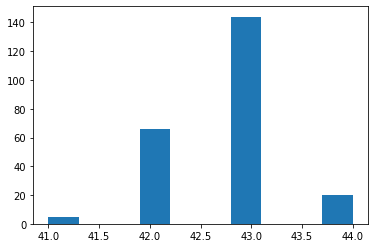

In [ ]:
"""
Plot the sequence length distribution of the batches in the train dataloader.
Make sure that all batches have difference sequence lengths.

Do NOT modify.
"""

batch_len = []
for batch_x, _, _ in train_dataloader:
    batch_len.append(batch_x.size(0))
plt.hist(batch_len)

# Model

In [ ]:
## vocab_size <- 전체 단어들의 개수 (encoder의 size)
## input_size <- embedding size
## hidden_size <- hidden state node 개수
## num_class <- class의 개수

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_class):
        """
        Define the model weight parameters and initialize the weights.

        Question (b)
        - Complete the dimension and shape of the weights and biases.
        - Use the model parameters (vocab_size, input_size, hidden_size, num_class).
        """
        super(RNN, self).__init__()

        ### COMPLETE HERE ###
        whh_size = (hidden_size, hidden_size)
        wxh_size = (input_size, hidden_size)
        why_size = (hidden_size, num_class)
        bhh_size = (1, hidden_size)
        bxh_size = (1, hidden_size)
        bhy_size = (1, num_class)
        ### COMPLETE HERE ###

        kwargs = {'device': DEVICE, 'dtype': torch.float}
        self.hidden = hidden_size
        self.num_class = num_class
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.W_hh = nn.parameter.Parameter(torch.empty(whh_size, **kwargs))
        self.W_xh = nn.parameter.Parameter(torch.empty(wxh_size, **kwargs))
        self.W_hy = nn.parameter.Parameter(torch.empty(why_size, **kwargs))
        self.b_hh = nn.parameter.Parameter(torch.empty(bhh_size, **kwargs))
        self.b_xh = nn.parameter.Parameter(torch.empty(bxh_size, **kwargs))
        self.b_hy = nn.parameter.Parameter(torch.empty(bhy_size, **kwargs))

        self.init_parameters()

    def init_parameters(self):
        """
        Initialize the parameters with Kaiming uniform initialization.

        Do NOT modify this method.
        """
        nn.init.kaiming_uniform_(self.W_hh, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_hh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_hh, -bound, bound)
        nn.init.kaiming_uniform_(self.W_xh, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_xh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_xh, -bound, bound)
        nn.init.kaiming_uniform_(self.W_hy, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_hy)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_hy, -bound, bound)

    def forward(self, inputs, length):
        """
        Question (c)
        - Passes a sequence of tokens into the recurrent network.
        - Randomly initialize h_0 with appropriate shape.
        - We do not want to use a hidden cell of a zero-padded token for classification!
        - Index the hidden state of the last valid token (excluding the zero-padding)
          based on the token length of each example in the batch.

        Inputs
        - a batch of encoded token sequences with shape (SEQ_LEN, BATCH_SIZE)
        - a batch of token lengths with shape (BATCH_SIZE)
        Returns
        - Softmax probabilites for each class with shape (BATCH_SIZE, NUM_CLASS)
        """
        ## input_size: sequence length        

        ### COMPLETE HERE ###
        h_0 = torch.randn(inputs.size(1), self.hidden).to(DEVICE)
        h_list = [h_0]
        embed = self.embedding.to(DEVICE)(inputs) # (SEQ_LEN, BATCH_SIZE, EMBEDDING_SIZE)
        h_prev = h_0
        for i in range(embed.size(0)):
            h_t = torch.tanh(torch.matmul(h_prev, self.W_hh) + torch.matmul(embed[i, :, :], self.W_xh) + self.b_hh + self.b_xh) # (BATCH_SIZE, HIDDEN_SIZE)
            h_list.append(h_t)
            h_prev = h_t

        valid_tokens = []
        for i in range(embed.size(1)):
            valid_token_len = length[i].item()
            if len(h_list) > valid_token_len: # if max > valid
                valid_token = h_list[valid_token_len][i, :]
            else:
                valid_token = h_list[-1][i, :]
            valid_tokens.append(valid_token) # (BATCH_SIZE, HIDDEN_SIZE)의 list

        y_hat = torch.matmul(torch.stack(valid_tokens).to(DEVICE), self.W_hy) + self.b_hy
        softmax_probs = F.softmax(y_hat, dim=1).to(DEVICE)

        ### COMPLETE HERE ###

        return softmax_probs
    
    def compute_loss(self, prediction, label):
        """
        Question (d)
        - Compute the cross entropy loss and the number of correct predictions
        - Do NOT use loss function in torch.nn library ex) nn.CrossEntropyLoss()
        - Hint: use torch.nn.functional.one_hot(tensor, num_classes=?) to generate one-hot encodings


        Inputs
        - prediction: output from self.forward(inputs) with shape (BATCH_SIZE, NUM_CLASS)
        - label: integer labels of the batch inputs with shape (BATCH_SIZE)
        Returns
        - cross entropy loss of the batch (float) and number of correct predictions (integer)
        """
        loss = 0
        correct = 0

        ### COMPLETE HERE ###
        
        label_one_hot = F.one_hot(label, num_classes=self.num_class).to(DEVICE)
        multiply = label_one_hot * torch.log(prediction).to(DEVICE)
        loss = (-(1/prediction.size(0)) * torch.sum(multiply)).to(DEVICE)
        correct = (torch.sum(torch.argmax(prediction, axis=1) == torch.argmax(label_one_hot, axis=1))).to(DEVICE)

        ### COMPLETE HERE ###

        return loss, correct

# Training Modules

In [ ]:
class ScheduledOptim():
    """
    Learning rate scheduler.

    Do NOT modify.
    """

    def __init__(self, optimizer, n_warmup_steps, decay_rate):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.decay = decay_rate
        self.n_steps = 0
        self.initial_lr = optimizer.param_groups[0]['lr']
        self.current_lr = optimizer.param_groups[0]['lr']

    def zero_grad(self):
        self._optimizer.zero_grad()
    
    def step(self):
        self._optimizer.step()
    
    def get_lr(self):
        return self.current_lr
    
    def update(self):
        if self.n_steps < self.n_warmup_steps:
            lr = self.n_steps / self.n_warmup_steps * self.initial_lr
        elif self.n_steps == self.n_warmup_steps:
            lr = self.initial_lr
        else:
            lr = self.current_lr * self.decay
        
        self.current_lr = lr
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

        self.n_steps += 1

In [ ]:
"""
Functions for training and evaluating the model.

Question (e)
- There has been minor changes with the model forward operation and loss computation.
  Compare the updates with the train, evaluate functions that we have previously used,
  and complete the train and evaluate function that works for the current model architecture.
- Use the methods of the scheduler to perform necessary operations on the optimizer.
- Do NOT change the arguments given to the train, evaluate functions.
"""

def train(model, train_loader, scheduler):
    model.train()
    train_loss = 0
    correct = 0
    
    ### COMPLETE HERE ###
    tqdm_bar = tqdm(train_loader)

    # scheduler.update()
    for text, label, length in tqdm_bar:
        text = text.to(DEVICE)
        label = label.to(DEVICE)
        length = length.to(DEVICE)

        scheduler.zero_grad()
        predicted = model.forward(text, length)
        loss, cor = model.compute_loss(predicted, label)
        loss.backward()
        
        train_loss += loss.item()
        correct += cor
        scheduler.step()
    
    scheduler.update()

    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    ### COMPLETE HERE ###
    
    return train_loss, train_acc

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    ### COMPLETE HERE ###
    tqdm_bar = tqdm(test_loader)

    for text, label, length in tqdm_bar:
        text = text.to(DEVICE)
        label = label.to(DEVICE)
        length = length.to(DEVICE)
        predicted = model.forward(text, length)
        loss, cor = model.compute_loss(predicted, label)
        test_loss += loss
        correct += cor

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    ### COMPLETE HERE ###

    return test_loss, test_acc

# Model Training

In [ ]:
"""
Question (f)
- Train your RNN model and obtain the test accuracy of 70%.
- Select the input size, hidden size of your choice
- Try various optimizer type, learning rate and scheduler options for the best performance.
"""

### COMPLETE HERE ###
EPOCHS = 30
vocab_size = len(encoder)
input_size = 512
hidden_size = 384
num_class = len(set([label for (label, text) in train_data]))

LR = 0.002

model = RNN(vocab_size, input_size, hidden_size, num_class)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = ScheduledOptim(optimizer, n_warmup_steps=4, decay_rate=0.8)
scheduler.update()

patience = 0 # for early-stopping
best_loss = np.inf
best_acc = 0
### COMPLETE HERE ###

for epoch in range(1, EPOCHS + 1):
    
    lr = scheduler.get_lr()
    loss_train, accu_train = train(model, train_dataloader, scheduler)
    loss_val, accu_val = evaluate(model, valid_dataloader)

    print('-' * 83)
    print('| end of epoch {:2d} | lr: {:5.4f} | train accuracy: {:8.3f} | train loss: {:5} |'
          'valid accuracy {:8.3f} | test loss: {:5}'.format(epoch, lr, accu_train, loss_train, accu_val, loss_val))
    print('-' * 83)

    if best_loss > loss_val:
        best_loss = loss_val
        patience = 0
    else:
        patience += 1
        if patience == 4:
            print(f"Early Stopping.\n")
            break

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  1 | lr: 0.0000 | train accuracy:   26.483 | train loss: 0.0060161253412564595 |valid accuracy   27.618 | test loss: 0.005983887240290642
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  2 | lr: 0.0005 | train accuracy:   46.421 | train loss: 0.0037854004775484404 |valid accuracy   66.750 | test loss: 0.0016480260528624058
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  3 | lr: 0.0010 | train accuracy:   77.924 | train loss: 0.0012433013883729775 |valid accuracy   81.382 | test loss: 0.0011589773930609226
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  4 | lr: 0.0015 | train accuracy:   85.163 | train loss: 0.0009569244009753068 |valid accuracy   83.961 | test loss: 0.0011469618184491992
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  5 | lr: 0.0020 | train accuracy:   81.101 | train loss: 0.001285773693273465 |valid accuracy   81.421 | test loss: 0.0014235499547794461
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  6 | lr: 0.0016 | train accuracy:   82.652 | train loss: 0.001140581553677718 |valid accuracy   82.684 | test loss: 0.0013295522658154368
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  7 | lr: 0.0013 | train accuracy:   81.854 | train loss: 0.00117076933508118 |valid accuracy   81.605 | test loss: 0.0012946263886988163
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  8 | lr: 0.0010 | train accuracy:   89.743 | train loss: 0.0006920429156472285 |valid accuracy   86.776 | test loss: 0.0009440180147066712
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  9 | lr: 0.0008 | train accuracy:   90.546 | train loss: 0.0006280183017253876 |valid accuracy   87.842 | test loss: 0.0008938407991081476
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 10 | lr: 0.0007 | train accuracy:   93.009 | train loss: 0.00046328261631230515 |valid accuracy   88.316 | test loss: 0.0008615960832685232
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 11 | lr: 0.0005 | train accuracy:   93.741 | train loss: 0.0004119177620857954 |valid accuracy   88.671 | test loss: 0.0008314630249515176
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 12 | lr: 0.0004 | train accuracy:   94.471 | train loss: 0.0003664507276068131 |valid accuracy   88.776 | test loss: 0.0008449904271401465
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 13 | lr: 0.0003 | train accuracy:   94.895 | train loss: 0.00033233037541309995 |valid accuracy   88.947 | test loss: 0.0008260603644885123
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 14 | lr: 0.0003 | train accuracy:   95.204 | train loss: 0.00031393723071863254 |valid accuracy   89.158 | test loss: 0.0008270732359960675
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 15 | lr: 0.0002 | train accuracy:   95.589 | train loss: 0.00029316317439079286 |valid accuracy   89.263 | test loss: 0.0008400438237003982
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 16 | lr: 0.0002 | train accuracy:   95.632 | train loss: 0.00028440113421529533 |valid accuracy   89.039 | test loss: 0.0008405733969993889
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 17 | lr: 0.0001 | train accuracy:   95.933 | train loss: 0.0002671219304203987 |valid accuracy   89.079 | test loss: 0.0008569627534598112
-----------------------------------------------------------------------------------
Early Stopping.

